<a href="https://colab.research.google.com/github/dAn-solution/competition/blob/main/Prob_kiva_011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kiva／クラウドファンディングの資金調達額予測
- LightGBM を実施

### Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'

Mounted at /content/drive
/content/drive/My Drive


### ライブラリのインストール、インポート

In [ ]:
# カレントディレクトリを変更
import os
os.chdir('/content/drive/My Drive/Probdata/kiva/')
print(os.getcwd())

/content/drive/My Drive/Probdata/kiva


In [ ]:
class Config():
    root_path = './'
    input_path = os.path.join(root_path, 'input')
    output_path = os.path.join(root_path, 'output')
    result_path = os.path.join(root_path, 'result')
    bert_model_name = 'bert-base-uncased'
    constant = 25
    seed = 42
    debug = False

In [ ]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb

### データの読み込み

In [ ]:
train_df = pd.read_csv(f'{Config.input_path}/train.csv')
test_df = pd.read_csv(f'{Config.input_path}/test.csv')
sample_df = pd.read_csv(f'{Config.input_path}/sample_submission.csv')

train_tags_pca = np.load(f'{Config.result_path}/train_tags_pca.npy')
test_tags_pca = np.load(f'{Config.result_path}/test_tags_pca.npy')
train_bert_pca = np.load(f'{Config.result_path}/train_bert_pca.npy')
test_bert_pca = np.load(f'{Config.result_path}/test_bert_pca.npy')
train_bert_018_pca = np.load(f'{Config.result_path}/train_bert_018_pca.npy')
test_bert_018_pca = np.load(f'{Config.result_path}/test_bert_018_pca.npy')

train_X_pca = np.load(f'{Config.result_path}/train_X_pca.npy')
test_X_pca = np.load(f'{Config.result_path}/test_X_pca.npy')

## LGBMの実行

In [ ]:
# # trainデータを目的変数と説明変数に分割
# train_columns = ["ORIGINAL_LANGUAGE", "ACTIVITY_NAME", "SECTOR_NAME", "COUNTRY_CODE","CURRENCY_POLICY",
#        "CURRENCY","REPAYMENT_INTERVAL", "DISTRIBUTION_MODEL"]
target_column = "LOAN_AMOUNT"

y = train_df[target_column]
# X = train_df[train_columns]
# test_X = test_df[train_columns]

In [ ]:
# ORIGINAL_LANGUAGEの EnglishとSpanishを選択
# language_list = list(X.reset_index().query('ORIGINAL_LANGUAGE == "English"').index)
# temp_list = list(X.reset_index().query('ORIGINAL_LANGUAGE == "Spanish"').index)
# language_list = language_list + temp_list
# X = X.iloc[language_list]

# language_list = list(test_X.reset_index().query('ORIGINAL_LANGUAGE == "English"').index)
# temp_list = list(test_X.reset_index().query('ORIGINAL_LANGUAGE == "Spanish"').index)
# language_list = language_list + temp_list
# test_X = test_X.iloc[language_list]
# del temp_list

In [ ]:
# # 説明変数をラベルエンコーディング
# warnings.simplefilter('ignore')
# for column in X.columns:
#   le = preprocessing.LabelEncoder()
#   target_column = X[column]
#   test_target_column = test_X[column]  
#   le.fit(target_column)
#   label_encoded_column = le.transform(target_column)
#   test_label_encoded_column = le.transform(test_target_column)
#   X[column] = pd.Series(label_encoded_column).astype("category")
#   test_X[column] = pd.Series(test_label_encoded_column).astype("category")

In [ ]:
train_pca = np.concatenate([train_X_pca, train_tags_pca, train_bert_pca, train_bert_018_pca], axis=1)
test_pca = np.concatenate([test_X_pca, test_tags_pca, test_bert_pca, test_bert_018_pca], axis=1)

# X = pd.concat([X, pd.DataFrame(train_pca)], axis=1)
# test_X = pd.concat([test_X, pd.DataFrame(test_pca)], axis=1)
X = pd.DataFrame(train_pca)
test_X = pd.DataFrame(test_pca)
print(X.shape)
print(test_X.shape)

(91333, 18)
(91822, 18)


In [ ]:
# trainデータを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = Config.seed)

In [ ]:
# LGBM用のパラメータ設定
lgb_params = {
    "application" : "regression_l1",
    'n_estimators': 500, 'learning_rate': 0.1,
    "metric" : "l1" #mae
}

# lgb_params = {
#     "application" : "regression_l1",
#     # 'objective': 'regression',
#     'importance_type': 'gain',
#     'metric': 'l1', # mae
#     'seed': Config.seed,
#     'n_jobs': -1,
#     'verbose': 0,

#     'n_estimators': 10000, 'learning_rate': 0.09,
#     'boosting_type': 'gbdt',
#     'subsample': 0.5, 'subsample_freq': 1,
#     'colsample_bytree': 0.5,
#     'num_leaves': 256, 'max_depth': -1, 'min_child_samples': 255,
#     'max_bin': 256,
# }

In [ ]:
# 学習/予測

# groups = X_train['LOAN_ID']
y_oof = np.zeros(len(y_train))
meta_preds = []
y_preds = []
kf = StratifiedKFold(n_splits=5)
for fold, (tr_idx, vl_idx) in enumerate(kf.split(X_train, y_train)):
    x_tr_fold = X.iloc[tr_idx]
    y_tr_fold = y.iloc[tr_idx]
    x_vl_fold = X.iloc[vl_idx]
    y_vl_fold = y.iloc[vl_idx]

    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(
        x_tr_fold, y_tr_fold,
        eval_set=(x_vl_fold, y_vl_fold),
        eval_metric='l1',
        verbose=False,
        early_stopping_rounds=100,
    )
    y_oof[vl_idx] = model.predict(x_vl_fold)
    meta_preds.append(model.predict(X))
    y_preds.append(model.predict(test_X))
    print(
        f'fold {fold} score:', mean_absolute_error(y_oof[vl_idx], y_vl_fold)
    )

print('X score:', mean_absolute_error(model.predict(X), y))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


fold 0 score: 339.83075039778345
fold 1 score: 325.97157722364796
fold 2 score: 321.48924799387987
fold 3 score: 327.1274279185328
fold 4 score: 335.1349494271071
X score: 279.3856555230936


In [ ]:
# メタモデルへの引き渡し
train_011_df = pd.DataFrame(np.mean(meta_preds, axis=0))
train_011_df.to_csv(os.path.join(Config.result_path, "train_011.csv"), index=False)

test_011_df = pd.DataFrame(np.mean(y_preds, axis=0))
test_011_df.to_csv(os.path.join(Config.result_path, "test_011.csv"), index=False)

In [ ]:
train_011_df.describe()

,0
count,91333.000000
mean,737.873254
std,797.359425
min,-86.791668
25%,332.747389
50%,524.987476
75%,820.144141
max,10580.819671


### 提出データの作成

In [ ]:
result = np.median(y_preds, axis=0)
for i in range(len(result)):
    a, b = divmod(result[i], Config.constant)
    if b > (Config.constant/2):
        b = 1
    else:
        b = 0
    result[i] = (a + b) * Config.constant
result[result<=0] = Config.constant 

In [ ]:
sample_df["LOAN_AMOUNT"] = result
print(sample_df)

       LOAN_ID  LOAN_AMOUNT
0      2041445        300.0
1      1944435        625.0
2      2083354        425.0
3      1993565        575.0
4      2064272        250.0
...        ...          ...
91817  1993862        350.0
91818  2015070        300.0
91819  1950349        475.0
91820  1921580       1625.0
91821  1976733        475.0

[91822 rows x 2 columns]


In [ ]:
# submitファイルのファイル名に利用する作成時刻の取得

now = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=1)))
date_time = "{0:%Y%m%d_%H%M}".format(now)

In [ ]:
# submitファイルの出力(Google Driveに出力）
# 形式：submit_yyyymmdd_hhmm.csv

sample_df.to_csv(os.path.join(Config.output_path, f"submit_{date_time}.csv"), index=False)


In [ ]:
train_011_df[train_011_df[0]< 13]

,0
4908,11.004530
11766,-34.233719
12258,-23.241154
16040,-40.295928
34340,-30.751877
35456,9.806276
47260,-53.823670
48415,-53.823670
48767,-15.176645
49607,-14.742287


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


    VIF Factor  features
0     1.087250         0
1     1.069703         1
2     1.038626         2
3     1.088255         3
4     1.008928         4
5     1.017949         5
6     1.113226         6
7     1.007598         7
8     1.027625         8
9     1.102076         9
10    1.206436        10
11    1.114720        11
12    1.050056        12
13    1.105010        13
14    1.044319        14
15    1.078129        15
16    1.197200        16
17    1.110732        17


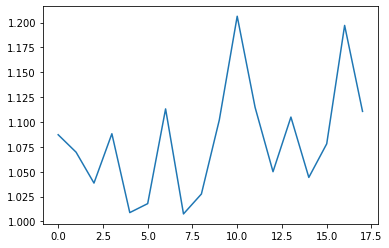

In [ ]:
#vifを計算する
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
 
#vifを計算結果を出力する
print(vif)
 
#vifをグラフ化する
plt.plot(vif["VIF Factor"])
